In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Input
import keras
from keras.callbacks import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [2]:
# Função para carregar e preprocessar os dados
def data():
    # Importando dados
    data = pd.read_excel(r'Conjunto de Dados Completo Original.xlsx')
    data = data[['Chuva_observada (mm)', 'Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]
    
    # Definindo parâmetros
    sequence_length = 12
    batch_size = 32
    train_cut = int(0.7 * len(data))
    
    # Escalonando todos os dados para o intervalo entre 0 e 1
    scaler = MinMaxScaler()
    scaler.fit(data[:train_cut])
    data_scaled = scaler.transform(data)
    
    scaler_Y = MinMaxScaler()
    scaler_Y.fit(data[['ENA_Grande (MWmed)']][:train_cut])
    
    # Convertendo o array numpy de volta para um DataFrame
    data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    
    # Separando inputs e targets
    inputs = data_scaled_df[['Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]
    inputs = inputs.iloc[:-sequence_length]
    targets = data_scaled_df.loc[sequence_length:, 'ENA_Grande (MWmed)']
    
    # Criando o dataset
    full_dataset = timeseries_dataset_from_array(
        inputs,
        targets,
        sequence_length=sequence_length,
        batch_size=batch_size,
        shuffle=False
    )
    
    # Converte o dataset em listas de arrays para divisão
    inputs_list = []
    targets_list = []

    for batch in full_dataset:
        batch_inputs, batch_targets = batch
        inputs_list.extend(batch_inputs.numpy())
        targets_list.extend(batch_targets.numpy())

    # Converte listas para arrays
    inputs_array = np.array(inputs_list)
    targets_array = np.array(targets_list)

    # Divide os dados em treinamento, validação e teste (70%, 20%, 10%)
    train_size = int(0.7 * len(inputs_array))
    val_size = int(0.2 * len(inputs_array))
    test_size = len(inputs_array) - train_size - val_size

    x_train = inputs_array[:train_size]
    y_train = targets_array[:train_size]

    x_val = inputs_array[train_size:train_size + val_size]
    y_val = targets_array[train_size:train_size + val_size]

    x_test = inputs_array[train_size + val_size:]
    y_test = targets_array[train_size + val_size:]

    # Cria datasets de treinamento, validação e teste
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    
    return inputs_array, train_dataset, val_dataset, test_dataset

# Função para criar e compilar o modelo
def create_model(params, inputs, train_dataset, val_dataset):
    model = Sequential()
    model.add(Input(shape=(inputs.shape[1], inputs.shape[2])))
    model.add(LSTM(units=params['units'], return_sequences=True))
    model.add(LSTM(units=params['units']))
    model.add(Dense(1))

    # Selecionando o otimizador com base nos parâmetros
    if params['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss="mse")
    
    earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, patience=30)
    mcp_save = ModelCheckpoint('trained_models/LSTM.keras', save_best_only=True, monitor='val_loss')

    model.fit(train_dataset, epochs=5000, validation_data=val_dataset, callbacks=[earlyStopping, mcp_save], verbose=0)
    
    val_loss = model.evaluate(val_dataset, verbose=0)
    # Retornando os parâmetros junto com a perda de validação e o modelo
    return {'loss': val_loss, 'status': STATUS_OK, 'model': model, 'params': params}

# Função de otimização
def optimize_lstm(params):
    inputs, train_dataset, val_dataset, test_dataset = data()
    result = create_model(params, inputs, train_dataset, val_dataset)
    return result

# Definição do espaço de busca
space = {
    'units': hp.choice('units', [1,2,3,4,8]),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop', 'sgd', 'nadam'])
}

# Realizando a otimização
trials = Trials()
best = fmin(optimize_lstm, space, algo=tpe.suggest, max_evals=200, trials=trials)

# Obtendo o melhor modelo
inputs, train_dataset, val_dataset, test_dataset = data()
best_params = trials.best_trial['result']['params']
best_model = trials.best_trial['result']['model']

print("Evaluation of best performing model:")
print(best_model.evaluate(test_dataset, verbose=0))
print("Best performing model chosen hyper-parameters:")
print(best_params)

# Salvando o melhor modelo
best_model.save('best_lstm_model_2.keras')
print("Best model saved as 'best_lstm_model_2.keras'")

100%|██████████| 200/200 [1:24:49<00:00, 25.45s/trial, best loss: 0.01052498072385788] 
Evaluation of best performing model:
0.006250038277357817
Best performing model chosen hyper-parameters:
{'learning_rate': 0.007342427098977078, 'optimizer': 'adam', 'units': 1}
Best model saved as 'best_lstm_model_2.keras'


In [3]:
# Importando dados
data = pd.read_excel(r'Conjunto de Dados Completo Original.xlsx')
data = data[['Chuva_observada (mm)', 'Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]
    
    # Definindo parâmetros
sequence_length = 12
batch_size = 32
train_cut = int(0.7 * len(data))
    
# Escalonando todos os dados para o intervalo entre 0 e 1
scaler = MinMaxScaler()
scaler.fit(data[:train_cut])
data_scaled = scaler.transform(data)
    
scaler_Y = MinMaxScaler()
scaler_Y.fit(data[['ENA_Grande (MWmed)']][:train_cut])
    
# Convertendo o array numpy de volta para um DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    
# Separando inputs e targets
inputs = data_scaled_df[['Chuva_Acum (mm)', 'ENA_Grande (MWmed)']]
inputs = inputs.iloc[:-sequence_length]
targets = data_scaled_df.loc[sequence_length:, 'ENA_Grande (MWmed)']
    
# Criando o dataset
full_dataset = timeseries_dataset_from_array(
    inputs,
    targets,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)
    
# Converte o dataset em listas de arrays para divisão
inputs_list = []
targets_list = []

for batch in full_dataset:
    batch_inputs, batch_targets = batch
    inputs_list.extend(batch_inputs.numpy())
    targets_list.extend(batch_targets.numpy())

# Converte listas para arrays
inputs_array = np.array(inputs_list)
targets_array = np.array(targets_list)

# Divide os dados em treinamento, validação e teste (70%, 20%, 10%)
train_size = int(0.7 * len(inputs_array))
val_size = int(0.2 * len(inputs_array))
test_size = len(inputs_array) - train_size - val_size

x_train = inputs_array[:train_size]
y_train = targets_array[:train_size]

x_val = inputs_array[train_size:train_size + val_size]
y_val = targets_array[train_size:train_size + val_size]

x_test = inputs_array[train_size + val_size:]
y_test = targets_array[train_size + val_size:]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


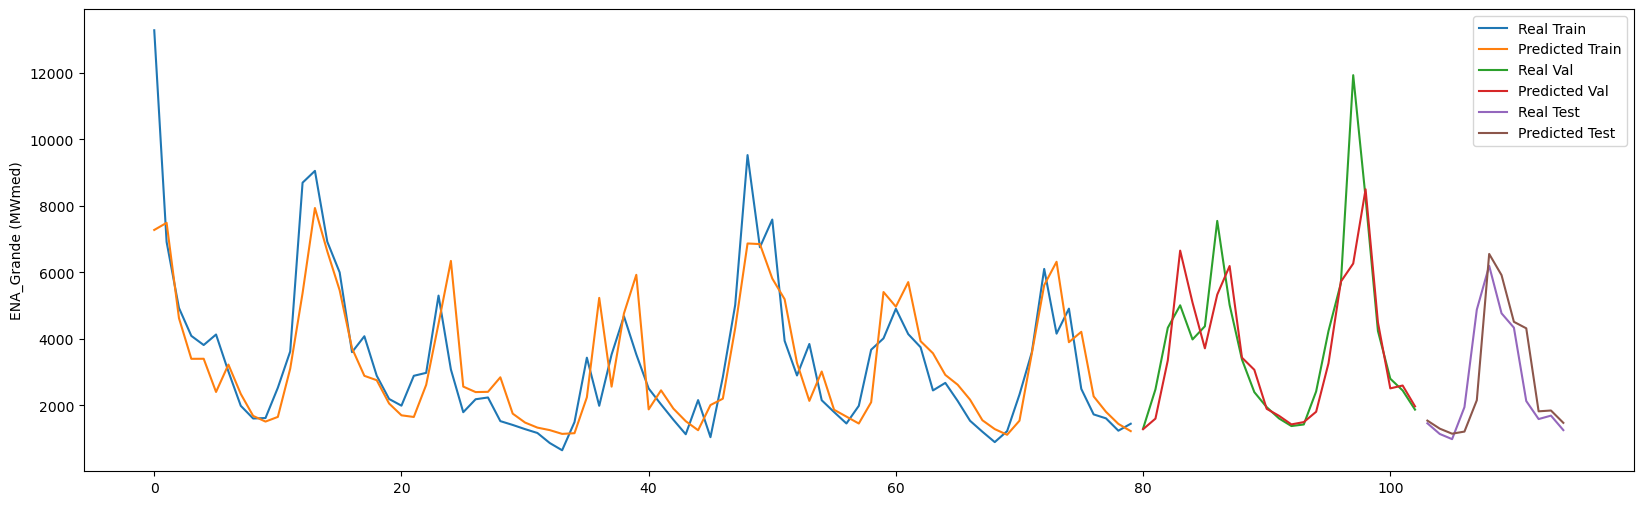

In [4]:


# Faz previsões
train_predict = best_model.predict(x_train)
val_predict = best_model.predict(x_val)
test_predict = best_model.predict(x_test)

# inverso das previsões
train_predict_inv = scaler_Y.inverse_transform(train_predict.reshape(-1, 1))
val_predict_inv = scaler_Y.inverse_transform(val_predict.reshape(-1, 1))
test_predict_inv = scaler_Y.inverse_transform(test_predict.reshape(-1, 1))

# Inverso dos valores reais
train_real_inv = scaler_Y.inverse_transform(y_train.reshape(-1, 1))
val_real_inv = scaler_Y.inverse_transform(y_val.reshape(-1, 1))
test_real_inv = scaler_Y.inverse_transform(y_test.reshape(-1, 1))

# Plota os resultados
plt.figure(figsize=(20,6))
plt.plot(train_real_inv.flatten(), label='Real Train')
plt.plot(train_predict_inv.flatten(), label='Predicted Train')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), val_real_inv.flatten(), label='Real Val')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), val_predict_inv.flatten(), label='Predicted Val')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), test_real_inv.flatten(), label='Real Test')
plt.plot(np.arange(len(y_train) + len(y_val), len(y_train) + len(y_val) + len(y_test)), test_predict_inv.flatten(), label='Predicted Test')
plt.legend()
plt.ylabel('ENA_Grande (MWmed)')
plt.show()

In [9]:
# Função para calcular as métricas
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)
    return mae, rmse, mape, r2, correlation

# Calcula métricas para o conjunto de treinamento
train_mae, train_rmse, train_mape, train_r2, train_correlation = calculate_metrics(train_real_inv.flatten(), train_predict_inv.flatten())

# Calcula métricas para o conjunto de validação
val_mae, val_rmse, val_mape, val_r2, val_correlation = calculate_metrics(val_real_inv.flatten(), val_predict_inv.flatten())

# Calcula métricas para o conjunto de teste
test_mae, test_rmse, test_mape, test_r2, test_correlation = calculate_metrics(val_real_inv.flatten(), val_predict_inv.flatten())

In [7]:
# Imprime os resultados
print("Modelo LSTM:")
print(f"Conjunto de treinamento: MAE = {train_mae}, RMSE = {train_rmse}, MAPE = {train_mape}, R^2 = {train_r2}, Correlation = {train_correlation}")
print(f"Conjunto de validação: MAE = {val_mae}, RMSE = {val_rmse}, MAPE = {val_mape}, R^2 = {val_r2}, Correlation = {val_correlation}")


Modelo LSTM:
Conjunto de treinamento: MAE = 837.4178009033203, RMSE = 1269.0582767059063, MAPE = 27.898364214371483, R^2 = 0.6811527015176404, Correlation = 0.8261217667009116
Conjunto de validação: MAE = 782.4116104789402, RMSE = 1422.2236930247689, MAPE = 15.690032128667081, R^2 = 0.6802914008652738, Correlation = 0.8339413885642835


NameError: name 'test_mae' is not defined

In [10]:
print(f"Conjunto de teste: MAE = {test_mae}, RMSE = {test_rmse}, MAPE = {test_mape}, R^2 = {test_r2}, Correlation = {test_correlation}")

Conjunto de teste: MAE = 782.4116104789402, RMSE = 1422.2236930247689, MAPE = 15.690032128667081, R^2 = 0.6802914008652738, Correlation = 0.8339413885642835
